# Assignment 8

Develop a model for 20 news groups dataset from scikit-learn. Select 20% of data for test set.  

Develop metric learning model with siamese network [3 points] and triplet loss [3 points] (from seminar). 
Use KNN and LSH (any library for approximate nearest neighbor search) for final prediction after the network was trained. [2 points]

! Remember, that LSH gives you a set of neighbor candidates, for which you have to calculate distances to choose top-k nearest neighbors. 

Your quality metric = accuracy score [2 points if acc > 0.8 ]

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer

import torch as tt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from random import randrange, sample
from math import ceil
from tqdm import tqdm_notebook, tqdm
# I will use https://github.com/spotify/annoy library
!pip install annoy
from annoy import AnnoyIndex
from datetime import datetime


RANDOM_STATE = 42
DEVICE = 'cuda'

Requirement already up-to-date: sentence-transformers in /usr/local/lib/python3.6/dist-packages (0.2.5)


In [0]:
X, y = fetch_20newsgroups('data', subset='all', return_X_y=True, random_state=RANDOM_STATE)

In [0]:
df = pd.DataFrame({'X': X, 'y': y})

In [0]:
df = df.sample(frac=1).reset_index(drop=True)

In [5]:
df.describe()

,y
count,18846.000000
mean,9.293166
std,5.562798
min,0.000000
25%,5.000000
50%,9.000000
75%,14.000000
max,19.000000


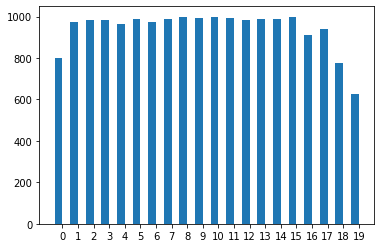

In [6]:
labels, values = zip(*sorted(Counter(df['y']).items()))
indexes = np.arange(len(labels))
width = 0.5

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

In [0]:
N = 10000
sentence_transformer = SentenceTransformer('bert-base-nli-mean-tokens')
embeddings = sentence_transformer.encode(df['X'][:N])

In [0]:
new_df = df[:N]

In [0]:
pd.options.mode.chained_assignment = None
new_df['embedding'] = tt.tensor(embeddings)

In [0]:
EMBED_SIZE = embeddings[0].shape[0]

In [0]:
df_train, df_test = train_test_split(new_df, test_size=0.2, random_state=RANDOM_STATE, shuffle=True)

In [0]:
df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=RANDOM_STATE, shuffle=True)

In [0]:
class_values = sorted(pd.unique(df['y']))

In [14]:
df_train.shape, df_test.shape, df_valid.shape

((6400, 3), (2000, 3), (1600, 3))

In [0]:
batch_size = 32

In [0]:
REPLACE = False

def get_random_batch(df):
    rows = df.sample(batch_size)
    anchors = list(rows.embedding)
    classes = list(rows.y)
    positive = []
    negative = []
    for i, class_ in enumerate(classes):
        positive_df = df[df['y'] == class_].sample(2, replace=REPLACE).reset_index(drop=True)
        if positive_df.embedding[0] == anchors[i]:
            positive.append(positive_df.embedding[1])
        else:
            positive.append(positive_df.embedding[0])
        negative_df = df[df['y'] != class_].sample(2, replace=REPLACE).reset_index(drop=True)
        if negative_df.embedding[0] == anchors[i]:
            negative.append(negative_df.embedding[1])
        else:
            negative.append(negative_df.embedding[0])
    return tt.tensor(negative, requires_grad=True), tt.tensor(anchors, requires_grad=True), tt.tensor(positive, requires_grad=True)

In [0]:
MAX_VALUE = int(10e9)
train_iterator = (get_random_batch(df_train) for _ in range(MAX_VALUE))
valid_iterator = (get_random_batch(df_valid) for _ in range(MAX_VALUE))
test_iterator = (get_random_batch(df_test) for _ in range(MAX_VALUE))

In [0]:
def _train_epoch(model, iterator, optimizer, curr_epoch, n_batches=1000):
    model.train()
    running_loss = 0

    tqdm_range = tqdm_notebook(range(n_batches), total=n_batches, desc='epoch %d' % (curr_epoch), leave=True)
    for i in tqdm_range:
        batch = next(iterator)
        optimizer.zero_grad()
        loss = model(batch)
        loss.backward()
        optimizer.step()
        curr_loss = loss.data.cpu().detach().item()
        loss_smoothing = i / (i+1)
        running_loss = loss_smoothing * running_loss + (1 - loss_smoothing) * curr_loss
        tqdm_range.set_postfix(loss='%.5f' % running_loss)

    return running_loss

In [0]:
def _test_epoch(model, iterator, n_batches=100):
    model.eval()
    epoch_loss = 0

    with tt.no_grad():
        for i in range(n_batches):
            batch = next(iterator)
            loss = model(batch)
            epoch_loss += loss.data.item()

    return epoch_loss / n_batches

In [0]:
def nn_train(model, train_iterator, valid_iterator, optimizer, n_epochs=10, scheduler=None, early_stopping=2):
    prev_loss = 100500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()

    for epoch in range(n_epochs):
        train_loss = _train_epoch(model, train_iterator, optimizer, epoch)
        valid_loss = _test_epoch(model, valid_iterator)
        print('validation loss %.5f' % valid_loss)

        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0
            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break
            prev_loss = min(prev_loss, valid_loss)

In [0]:
OUT_SIZE = 128

class SiameseNet(nn.Module):
    def __init__(self, criterion):
        super().__init__()
        self.criterion = criterion
        self.fc1 = nn.Linear(EMBED_SIZE, 512).cuda()
        self.fc2 = nn.Linear(512, 256).cuda()
        self.fc3 = nn.Linear(256, OUT_SIZE).cuda()


    def branch(self, x):
        return self.fc3(self.fc2(self.fc1(x)))


    def forward(self, batch):
        negative, anchor, positive = batch
        negative = self.branch(negative.to(DEVICE))
        anchor = self.branch(anchor.to(DEVICE))
        positive = self.branch(positive.to(DEVICE))
        loss = self.criterion(anchor, positive, negative)
        return loss

In [0]:
tt.cuda.empty_cache()
if hasattr(tqdm, '_instances'):
    for instance in list(tqdm._instances):
        tqdm._decr_instances(instance)

In [0]:
criterion = nn.TripletMarginLoss()
criterion = criterion.to(DEVICE)
model = SiameseNet(criterion).to(DEVICE)
optimizer = tt.optim.Adam(model.parameters())

In [24]:
nn_train(model, train_iterator, valid_iterator, optimizer, n_epochs=10, early_stopping=-1)


validation loss 0.55628



validation loss 0.54707



validation loss 0.43022



validation loss 0.41748



validation loss 0.40945



validation loss 0.42042



validation loss 0.45372



validation loss 0.41305



validation loss 0.41951



validation loss 0.42741


In [29]:
nn_train(model, train_iterator, valid_iterator, optimizer, n_epochs=15, early_stopping=-1)


validation loss 0.40423



validation loss 0.39962



validation loss 0.44468



validation loss 0.43443



validation loss 0.38658



validation loss 0.40768



validation loss 0.41186



validation loss 0.43839



validation loss 0.40806



validation loss 0.39523



validation loss 0.43580



validation loss 0.41953



validation loss 0.39474



validation loss 0.35993



validation loss 0.43680


In [33]:
nn_train(model, train_iterator, valid_iterator, optimizer, n_epochs=15, early_stopping=-1)


validation loss 0.39048



validation loss 0.43861



validation loss 0.44044



validation loss 0.38599



validation loss 0.39209



validation loss 0.43156



validation loss 0.43668



validation loss 0.40481



validation loss 0.42438



validation loss 0.41037



validation loss 0.41072



validation loss 0.42099



validation loss 0.42996



validation loss 0.44888



validation loss 0.44438


In [0]:
NUM_OF_VARS = 50

def count_accuracy(df):
    TP = 0
    model.eval()
    with tt.no_grad():
        for i, (v, y) in enumerate(zip(df.embedding, df.y)):
            our_pred = t.get_nns_by_vector(model.branch(tt.tensor(v).to(DEVICE)), NUM_OF_VARS)
            our_pred = Counter(our_pred).most_common(1)[0][0]
            TP += (y == our_pred)
    return TP / df.shape[0]

In [0]:
t = AnnoyIndex(OUT_SIZE, "angular")  # Length of item vector that will be indexed

In [35]:
model.eval()
with tt.no_grad():
    for v, y in zip(df_train.embedding, df_train.y):
        v = tt.tensor(v).to(DEVICE)
        t.add_item(y, model.branch(v))
t.build(n_trees=-1)

True

In [36]:
print(f'test accuracy: {count_accuracy(df_test) }\nvalid accuracy: {count_accuracy(df_valid)}\ntrain accuracy: {count_accuracy(df_train)}')

test accuracy: 0.3745
valid accuracy: 0.38
train accuracy: 0.416875
